In [2]:
%matplotlib
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy.linalg import solve


Using matplotlib backend: module://matplotlib_inline.backend_inline


In [3]:

# Параметры
eps = 0.01
h = 0.1  # шаг по времени
t_max = 1500
N = int(t_max / h)


In [4]:
def f(X):
    x, y, alpha = X
    dx = x * (1 - 0.5 * x - (2 / (7 * alpha**2)) * y)
    dy = y * (2 * alpha - 3.5 * alpha**2 * x - 0.5 * y)
    dalpha = eps * (2 - 7 * alpha * x)
    return np.array([dx, dy, dalpha])

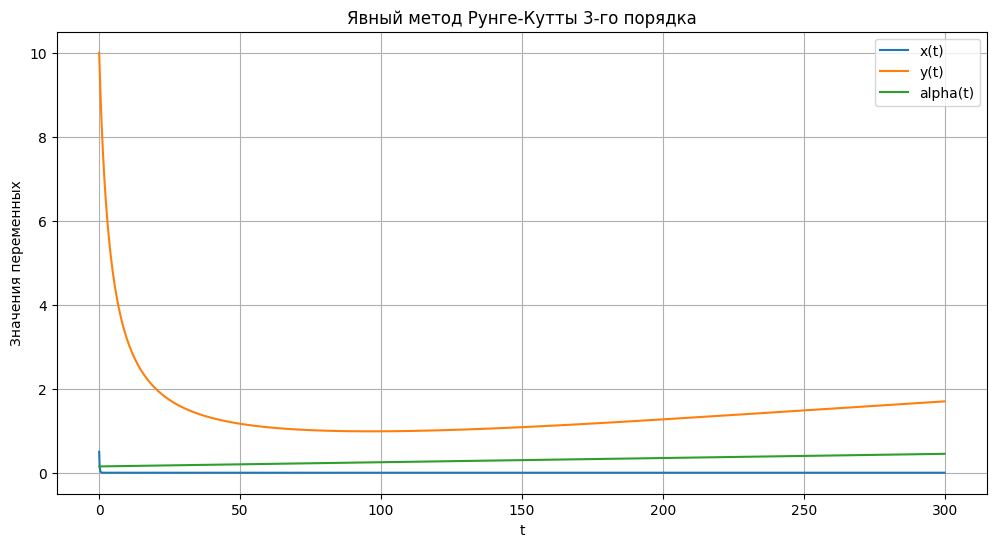

In [4]:

h = 0.001
t_max = 300


x0, y0, alpha0 = 0.5, 10.0, 0.15

t = np.linspace(0, t_max, N+1)
X = np.zeros((N+1, 3))
X[0] = [x0, y0, alpha0]

# Реализация явного РК3
for n in range(N):
    Xn = X[n]
    k1 = f(Xn)
    k2 = f(Xn + h * k1 / 2)
    k3 = f(Xn - h * k1 + 2 * h * k2)
    X[n+1] = Xn + h * (k1 + 4 * k2 + k3) / 6

# Построение графиков
plt.figure(figsize=(12, 6))
plt.plot(t, X[:, 0], label='x(t)')
plt.plot(t, X[:, 1], label='y(t)')
plt.plot(t, X[:, 2], label='alpha(t)')
plt.xlabel('t')
plt.ylabel('Значения переменных')
plt.title('Явный метод Рунге-Кутты 3-го порядка')
plt.legend()
plt.grid(True)
plt.show()


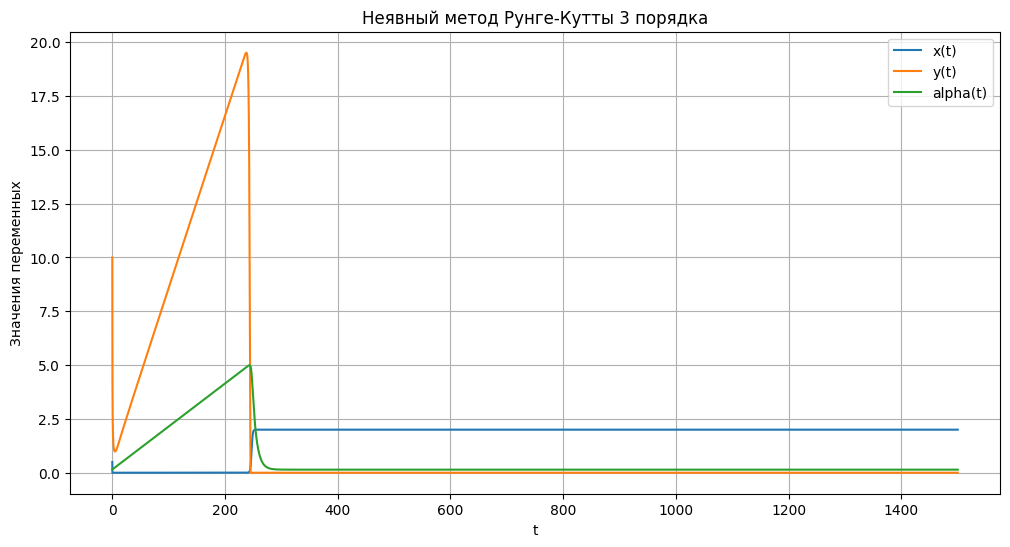

In [28]:

eps = 0.01
h = 0.01
t_max = 1500
N = int(t_max / h)


x0, y0, alpha0 = 0.5, 10.0, 0.15
X = np.zeros((N+1, 3))
X[0] = [x0, y0, alpha0]
t = np.linspace(0, t_max, N+1)


A = np.array([[5/12, -1/12],
              [3/4,   1/4]])
b = np.array([3/4, 1/4])


def implicit_rk3_step(Xn, h, max_iter=10):

    K1 = f(Xn)
    K2 = K1.copy()

    for _ in range(max_iter):
        Y1 = Xn + h * (A[0,0] * K1 + A[0,1] * K2)
        Y2 = Xn + h * (A[1,0] * K1 + A[1,1] * K2)
        F1 = f(Y1)
        F2 = f(Y2)
        K1 = F1
        K2 = F2

    return Xn + h * (b[0] * K1 + b[1] * K2)


for n in range(N):
    X[n+1] = implicit_rk3_step(X[n], h)


plt.figure(figsize=(12, 6))
plt.plot(t, X[:, 0], label='x(t)')
plt.plot(t, X[:, 1], label='y(t)')
plt.plot(t, X[:, 2], label='alpha(t)')
plt.xlabel('t')
plt.ylabel('Значения переменных')
plt.title('Неявный метод Рунге-Кутты 3 порядка')
plt.legend()
plt.grid(True)
plt.show()


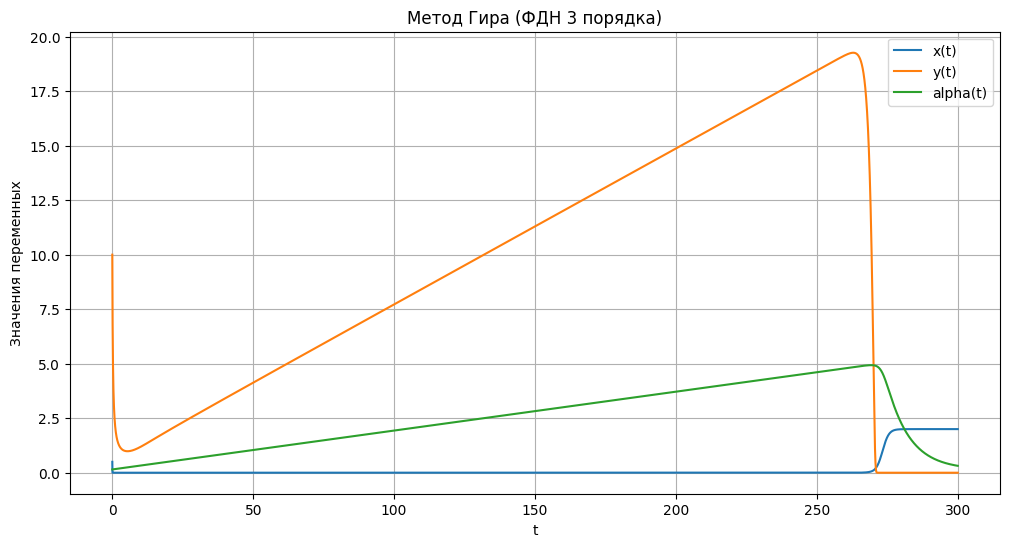

In [14]:


eps = 0.01
h = 0.01
t_max = 300
N = int(t_max / h)
t = np.linspace(0, t_max, N+1)


x0, y0, alpha0 = 0.5, 10.0, 0.15
X = np.zeros((N+1, 3))
X[0] = [x0, y0, alpha0]



def rk3_step(Xn):
    k1 = f(Xn)
    k2 = f(Xn + h * k1 / 2)
    k3 = f(Xn - h * k1 + 2 * h * k2)
    return Xn + h * (k1 + 4 * k2 + k3) / 6

X[1] = rk3_step(X[0])
X[2] = rk3_step(X[1])


def gear3_step(X_hist):
    Xn2, Xn1, Xn = X_hist
    X_guess = (18*Xn - 9*Xn1 + 2*Xn2) / 11
    for _ in range(10):
        f_val = f(X_guess)
        X_new = (18*Xn - 9*Xn1 + 2*Xn2 + 6*h*f_val) / 11
        X_guess = 0.8 * X_guess + 0.2 * X_new
    return X_guess

for n in range(2, N):
    X[n+1] = gear3_step(X[n-2:n+1])


plt.figure(figsize=(12, 6))
plt.plot(t, X[:, 0], label='x(t)')
plt.plot(t, X[:, 1], label='y(t)')
plt.plot(t, X[:, 2], label='alpha(t)')
plt.xlabel('t')
plt.ylabel('Значения переменных')
plt.title('Метод Гира (ФДН 3 порядка)')
plt.legend()
plt.grid(True)
plt.show()


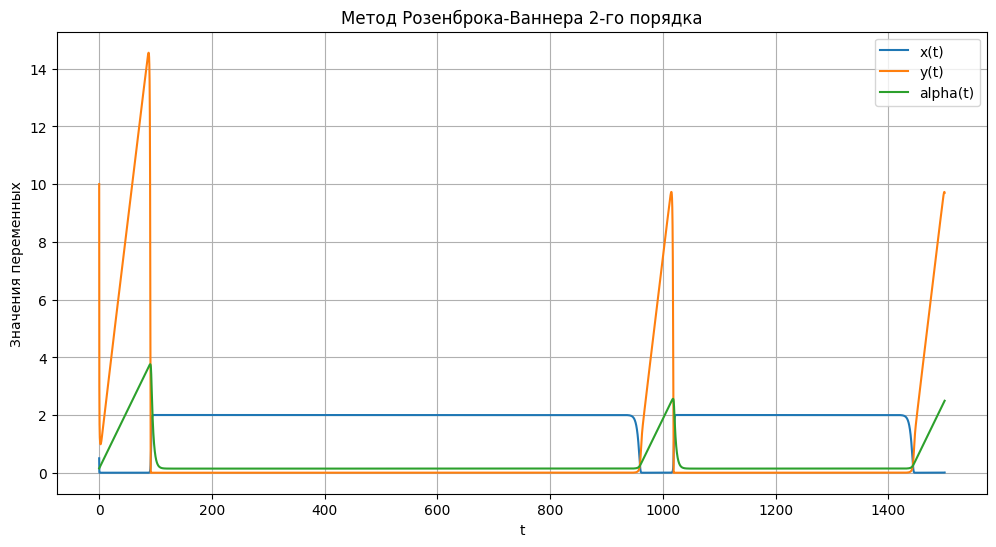

In [27]:


epsilon = 0.01
tau = 1.0



def system_jacobian(state):
    x, y, a = state
    J = np.zeros((3, 3))


    J[0, 0] = 1 - x - (2/(tau*a**2))*y
    J[0, 1] = - (2/(tau*a**2)) * x
    J[0, 2] = (4/(tau*a**3)) * x * y


    J[1, 0] = -3.5 * a**2 * y
    J[1, 1] = 2*a - 3.5*a**2*x - y
    J[1, 2] = 2*y - 7*a*x*y


    J[2, 0] = -epsilon * tau * a
    J[2, 1] = 0.0
    J[2, 2] = -epsilon * tau * x

    return J


def rosenbrock_step(state, h):
    gamma = 1.0 + np.sqrt(2)/2
    I = np.eye(3)
    fu = f(state)
    J = system_jacobian(state)


    A = I - gamma * h * J
    k1 = solve(A, h * fu)


    f_new = f(state + k1)


    b = h * (f_new + gamma * k1)
    k2 = solve(A, b)


    new_state = state + 1.5*k1 + 0.5*k2
    return new_state


def solve_system(x0, y0, a0, Tk, h=0.1):
    t = 0.0
    state = np.array([x0, y0, a0], dtype=np.float64)
    times = [t]
    states = [state.copy()]

    while t < Tk:
        state = rosenbrock_step(state, h)
        t += h
        times.append(t)
        states.append(state.copy())


        if state[2] < 1e-8:
            raise ValueError("a small!!!")

    return np.array(times), np.array(states)


x0, y0, a0 = 0.5, 10.0, 0.15


t, X = solve_system(x0, y0, a0, 1500, h=0.01)


plt.figure(figsize=(12, 6))
plt.plot(t, X[:, 0], label='x(t)')
plt.plot(t, X[:, 1], label='y(t)')
plt.plot(t, X[:, 2], label='alpha(t)')
plt.xlabel('t')
plt.ylabel('Значения переменных')
plt.title('Метод Розенброка-Ваннера 2-го порядка')
plt.legend()
plt.grid(True)
plt.show()